<a href="https://colab.research.google.com/github/hoangviet-nguyen/bveri-abschluss-projekt/blob/main/projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

try:
    import jupyter_black

    jupyter_black.load()
except:
    print("black not installed")

In [2]:
try:
    from google.colab import drive
    import sys

    DATA_PATH = "/content/drive"
    drive.mount(DATA_PATH)
    sys.path.append("/content/drive/MyDrive/Bveri-Abschluss")
    DATA_PATH = DATA_PATH + "/MyDrive/Bveri-Abschluss/workspace/code/data"
    IN_COLAB = True
    %pip install torchinfo torchshow -q matplotlib
except ImportError:
    IN_COLAB = False
    DATA_PATH = "./workspace/code/data"
    print("Not running on Google Colab")

Not running on Google Colab


# Projekt: Under Water Image Segmentation

## Einleitung
 
In diesem Mini-Projekt werden mithilfe 2 Modellen Unterwasser Bilder Semantisch segmentiert. Die Aufgabe war ein eigenes Modell nach Intuition zu erstellen, trainieren und Testen. Danach sollten wir ein SUIM-Net Modell von der ursprünglichen [Arbeit](https://arxiv.org/abs/2004.01241) auswählen und diese dann trainieren und testen. Beide Modelle werden dann am Schluss Verglichen und diskutiert.
 
Die Modelle sollten die Unterwasser Bilder nach folgenden Kategorien segmentieren:
- Hintergrund
- Taucher
- Pflanzen & Seegrässer
- Wrack & Ruinen
- Roboter(AUVs/ROVs/Instrumente)
- Riffe & wirbellose Tiere
- Fische & Wirbeltiere
- Meeresboden & Gestein

In [3]:
import os
from pathlib import Path
import utils.SuimSet as SuimSet
from utils.SuimSet import SuimDataSet
from utils.utils import train_model, evaluate_model
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.v2 import functional as TF
import torch
import torchshow as ts
from torch.nn import functional as F
from models.Unet import Decoder, Encoder, UNet
from models.SuimNet import RSBEncoder, RSBDecoder, SuimNet
import torchinfo
from tqdm.notebook import tqdm

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Download dataset: SUIM dataset

Das SUIM Dataset sind in Training und Test Bilder aufgespaltet.
Die Bilder sind RGB Bilder im JPG Format.
Die Masken sind labels zu den Bilder im BMP Format.
 
Die Farben in den Masken korrespondieren zu den Kategorien:
 
| Kategorie      | linear RGB(0-1)      |
| ------------- | ------------- |
| Hintergrund | (0,0,0) |
| Taucher | (0,0,1) |
| Pflanzen & Seegrässer | (0,1,0) |
| Wrack & Ruinen | (0,1,1) |
| Roboter(AUVs/ROVs/Instrumente) | (1,0,0) |
| Riffe & wirbellose Tiere | (1,0,1) |
| Fische & Wirbeltiere | (1,1,0) |
| Meeresboden & Gestein | (1,1,1) |

In [5]:
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
    SuimSet.download(DATA_PATH)

## Data Inspection

In [6]:
import os

train_path = Path(DATA_PATH).joinpath("train_val/train_val")

trainingImages = os.listdir(train_path.joinpath("images"))
trainingMasks = os.listdir(train_path.joinpath("masks"))
lenTrainingImages = len(trainingImages)
lenTrainingMasks = len(trainingMasks)

trainingImage = Image.open(train_path.joinpath("images/" + trainingImages[0]))
trainingMask = Image.open(train_path.joinpath("masks/" + trainingMasks[0]))


test_path = Path(DATA_PATH).joinpath("TEST/TEST")

testImages = os.listdir(test_path.joinpath("images"))
testMasks = os.listdir(test_path.joinpath("masks"))

lenTestImages = len(testImages)
lenTestMasks = len(testMasks)

_, imageExtension = os.path.splitext(testImages[0])
_, maskExtension = os.path.splitext(testMasks[0])

print(f"Anz. Trainings-Bilder: {lenTrainingImages}")
print(f"Anz. Trainings-Masken: {lenTrainingMasks}")
print(f"Anz. Test-Bilder: {lenTestImages}")
print(f"Anz. Test-Masken: {lenTestMasks}")

print(f"Trainings-Bild Grösse: {trainingImage.size}")
print(f"Trainings-Maske Grösse: {trainingMask.size}")

print(f"Bild-Format: {imageExtension}")
print(f"Masken-Format: {maskExtension}")

Anz. Trainings-Bilder: 1525
Anz. Trainings-Masken: 1525
Anz. Test-Bilder: 110
Anz. Test-Masken: 118
Trainings-Bild Grösse: (640, 480)
Trainings-Maske Grösse: (640, 480)
Bild-Format: .jpg
Masken-Format: .bmp


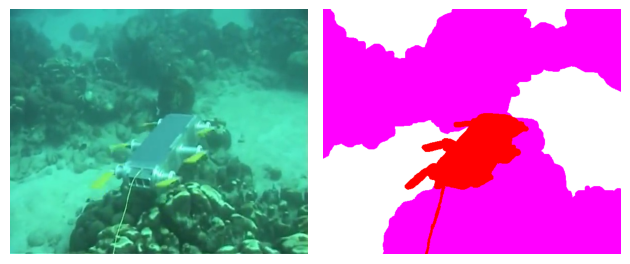

In [7]:
train_path = DATA_PATH + "/train_val/train_val"
norm_img = Image.open(train_path + "/images/d_r_1_.jpg")
norm_img = np.array(norm_img)

label_img = Image.open(train_path + "/masks/d_r_1_.bmp")
label_img = np.array(label_img) / 255
imgs = [norm_img, label_img]

fig, axs = plt.subplots(ncols=2)
for img, ax in zip(imgs, axs.flatten()):
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show();

In [8]:
train_path = Path(train_path)
test_path = Path(DATA_PATH).joinpath("TEST/TEST")

ds_train = SuimDataSet(root_path=train_path)
ds_test = SuimDataSet(root_path=test_path)

print(f"Anzahl Trainings Daten: {len(ds_train)}")
print(f"Anfangs Test Daten: {len(ds_test)}")

Anzahl Trainings Daten: 1525
Anfangs Test Daten: 110


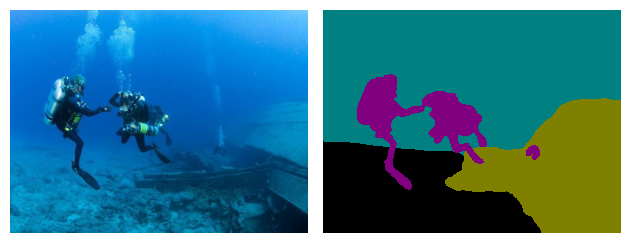

In [9]:
observation, label_masks, ground_truth = ds_train[0]
ts.show([observation, ground_truth])

## U-Net Modell

Das U-Net Modell wurde dazu genutzt um Bilder in der Medizin und der Biologie zu Segmentieren. Die [Arbeit](https://arxiv.org/abs/1505.04597) wurde von von Ronnenberger, Fischer und Brox entwickelt. 
Das U-Net Modell ist ein relativ simples Modell. Es besteht aus je 4 Blöcke im Encoder bereich und im Decoder bereich. Der Encoder besteht aus 2 Convolutions und einer Maxpool operation welche die Bilddimesionen
halbiert.

Im Decoder bereich werden zuerst die Activation Maps des Encoders vor dem Maxpool an diejeniegen des Decoders gehängt bevor sie durch eine Convolution auf die Ürspüngliche Dimension kommen. Dies stellt sicher, dass Informationen der Activation Maps mit hoher Auflösung im Encoder während dem Forward Pass nicht verloren gehen. Der rest des Blocks besteht aus einer Convolution und einer Transpose Convolution. Die Transpose Convolution halbiert die Anzahl der Activation Maps und verdoppelt die Bild Dimensionen.

In der Original Arbeit besteht der das U-Net aus je 4 Blöcken Encoder / Decoder und die Anzahl Activation Maps am Anfang beträgt 64. Wir fügen dem Modell je 2 weitere Blöcke hinzu und fangen mit 16 Activation Maps an. Dies führt zu einer stärkeren Kompression des Bildes.

<img src="./imgs/Unet.png" alt="Unet" width="700">

In [10]:
start = 16
encoder = Encoder(start=start, num_blocks=6)
decoder = Decoder(start=start, num_blocks=6)
unet = UNet(encoder=encoder, decoder=decoder, n_classes=8, start=start)
print(torchinfo.summary(unet, input_size=(4, 3, 512, 512)))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [4, 8, 512, 512]          --
├─Conv2d: 1-1                            [4, 16, 512, 512]         448
├─Encoder: 1-2                           [4, 32, 256, 256]         --
│    └─ModuleList: 2-1                   --                        --
│    │    └─EncoderBlock: 3-1            [4, 32, 256, 256]         13,952
│    │    └─EncoderBlock: 3-2            [4, 64, 128, 128]         55,552
│    │    └─EncoderBlock: 3-3            [4, 128, 64, 64]          221,696
│    │    └─EncoderBlock: 3-4            [4, 256, 32, 32]          885,760
│    │    └─EncoderBlock: 3-5            [4, 512, 16, 16]          3,540,992
│    │    └─EncoderBlock: 3-6            [4, 1024, 8, 8]           14,159,872
├─Decoder: 1-3                           [4, 16, 512, 512]         --
│    └─DecoderBlock: 2-2                 [4, 512, 16, 16]          --
│    │    └─Conv2d: 3-7                  [4, 512, 8

## Suim-Net Model
 
Wir haben uns entschieden das SUIM-Net RSB zu implementieren von der [Arbeit](https://arxiv.org/abs/2004.01241).
Das Modell implementiert ein optionales Residual-Skip-Block (RSB). Ein RSB besteht aus 3 Convolutions und einer optionalen 4 Convolutionen. Bei der 4 Convolution handelt es sich um eine skip connection welche lokales lernen fördern soll. Die Encoded Blöcke werden im decoder pass noch konkatiniert

Ein RSB ist wie folgt aufgebaut:<br>
<img src="./imgs/SUIM_Net_RSB.png" alt="SUIM-Net RSB" width="700">


Das ganze Modell sieht dann so aus:<br>
<img src="./imgs/RSB.png" alt="RSB" width="700">


In [11]:
encoder = RSBEncoder()
decoder = RSBDecoder(n_classes=8)
net = SuimNet(encoder=encoder, decoder=decoder)
print(torchinfo.summary(net, input_size=(16, 3, 320, 240)))

Layer (type:depth-idx)                   Output Shape              Param #
SuimNet                                  [16, 8, 320, 240]         --
├─RSBEncoder: 1-1                        [16, 64, 320, 240]        --
│    └─Conv2d: 2-1                       [16, 64, 320, 240]        4,864
│    └─BatchNorm2d: 2-2                  [16, 64, 320, 240]        128
│    └─ReLU: 2-3                         [16, 64, 320, 240]        --
│    └─MaxPool2d: 2-4                    [16, 64, 159, 119]        --
│    └─ModuleList: 2-5                   --                        --
│    │    └─RSB: 3-1                     [16, 128, 80, 60]         58,496
│    │    └─RSB: 3-2                     [16, 128, 80, 60]         70,784
│    │    └─RSB: 3-3                     [16, 128, 80, 60]         70,784
│    └─ModuleList: 2-6                   --                        --
│    │    └─RSB: 3-4                     [16, 256, 40, 30]         231,680
│    │    └─RSB: 3-5                     [16, 256, 40, 30]      

## **Model Training**

In diesem Abschnitt wird der Trainingsprozess der Modelle beschrieben. Dabei verwenden wir die Metrik **Pixel Accuracy**, um die Leistung während des Trainings zu verfolgen. Die Trainingsmethodik ist in der Datei `utils.py` implementiert. Ziel ist es, die Modelle zu optimieren und eine möglichst hohe Genauigkeit auf den Trainingsdaten zu erreichen, während Overfitting vermieden wird.


In [12]:
from torchvision import transforms

batch_size = 4
width = 512
height = 512

tr_images = transforms.Compose(
    [
        transforms.CenterCrop((width, height)),
        transforms.ToTensor(),
    ]
)
tr_labels = transforms.Compose(
    [
        transforms.CenterCrop((width, height)),
    ]
)

ds_train = SuimDataSet(
    train_path, transform_images=tr_images, transform_labels=tr_labels
)
train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size, shuffle=True
)

In [13]:
if IN_COLAB:
    suim_model_path = "/content/drive/MyDrive/Bveri-Abschluss/SuimNet.pth"
    unet_model_path = "/content/drive/MyDrive/Bveri-Abschluss/UNet_model.pth"
else:
    suim_model_path = "./models/params/SuimNet.pth"
    unet_model_path = "./models/params/UNet_model.pth"

In [14]:
import warnings

n_classes = len(ds_train.rgb_to_class)

rsb_encoder = RSBEncoder()
rsb_decoder = RSBDecoder(n_classes=n_classes)

start = 16
num_blocks = 6
unet_encoder = Encoder(start=start, num_blocks=num_blocks)
unet_decoder = Decoder(start=start, num_blocks=num_blocks)

if os.path.exists(suim_model_path) and os.path.exists(unet_model_path):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)

        suim_net = SuimNet(encoder=rsb_encoder, decoder=rsb_decoder)
        suim_net.load_state_dict(torch.load(suim_model_path))
        suim_net = suim_net.to(device)

        unet = UNet(
            encoder=unet_encoder, decoder=unet_decoder, start=start, n_classes=n_classes
        )

        unet.load_state_dict(torch.load(unet_model_path))
        unet = unet.to(device)

        MODEL_TRAINED = True
        print(f"Model loaded from {suim_model_path}")
        print(f"Model loaded from {unet_model_path}")
else:
    # create model
    suim_net = SuimNet(encoder=rsb_encoder, decoder=rsb_decoder)
    suim_net = suim_net.to(device)

    unet = UNet(
        encoder=unet_encoder, decoder=unet_decoder, start=start, n_classes=n_classes
    )
    unet = unet.to(device)

    MODEL_TRAINED = False
    print("Created SuimNet and Unet Model")

<All keys matched successfully>

<All keys matched successfully>

Model loaded from ./models/params/SuimNet.pth
Model loaded from ./models/params/UNet_model.pth


In [15]:
if not MODEL_TRAINED:
    train_model(model=suim_net, device=device, loader=train_loader)
    train_model(model=unet, device=device, loader=train_loader)
    torch.save(unet.state_dict(), unet_model_path)
    torch.save(suim_net.state_dict(), suim_model_path)
    print(f"Model saved to {unet_model_path}")
    print(f"Model saved to {suim_model_path}")

## **Model Evaluation**

In diesem Abschnitt werden die Ergebnisse der Modelle anhand bekannter Metriken wie **Pixel Accuracy**, **Dice Score** und **IoU** dargestellt. Die Implementierung der Evaluationsmethodik befindet sich in der Datei `utils.py`. Ziel ist es, die Leistung des **UNet-Modells** und des **SuimNet-Modells** zu vergleichen und deren Generalisierungsfähigkeit zu bewerten.


In [16]:
ds_test = SuimDataSet(test_path, transform_images=tr_images, transform_labels=tr_labels)
test_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size, shuffle=False
)

In [17]:
width = 320
height = 240

tr_images = transforms.Compose(
    [
        transforms.CenterCrop((width, height)),
        transforms.ToTensor(),
    ]
)
tr_labels = transforms.Compose(
    [
        transforms.CenterCrop((width, height)),
    ]
)

num_samples_test = len(ds_test)
num_samples_train = len(ds_train)

pixel_acc_test, iou_test, dice_test = evaluate_model(
    suim_net, test_loader, device, num_samples_test
)
pixel_acc_train, iou_train, dice_train = evaluate_model(
    suim_net, train_loader, device, num_samples_train
)

print(
    f"SuimNet Metrics Test: Pixel Accuracy: {pixel_acc_test:.4f}, IoU: {iou_test:.4f}, Dice Score: {dice_test:.4f}"
)
print(
    f"SuimNet Metrics Train: Pixel Accuracy: {pixel_acc_train:.4f}, IoU: {iou_train:.4f}, Dice Score: {dice_train:.4f}"
)

Iteration:   380] Acc: 0.096:  99%|█████████▉| 380/382 [03:28<00:01,  1.82it/s]

SuimNet Metrics Test: Pixel Accuracy: 0.1626, IoU: 1.0203, Dice Score: 1.5729
SuimNet Metrics Train: Pixel Accuracy: 0.1107, IoU: 0.0744, Dice Score: 0.1145


In [18]:
width = 512
height = 512

tr_images = transforms.Compose(
    [
        transforms.CenterCrop((width, height)),
        transforms.ToTensor(),
    ]
)
tr_labels = transforms.Compose(
    [
        transforms.CenterCrop((width, height)),
    ]
)

pixel_acc_test, iou_test, dice_test = evaluate_model(
    unet, test_loader, device, num_samples_test
)
pixel_acc_train, iou_train, dice_train = evaluate_model(
    unet, train_loader, device, num_samples_train
)
print(
    f"UNet Metrics: Pixel Accuracy: {pixel_acc_test:.4f}, IoU: {iou_test:.4f}, Dice Score: {dice_test:.4f}"
)
print(
    f"UNet Metrics Train: Pixel Accuracy: {pixel_acc_train:.4f}, IoU: {iou_train:.4f}, Dice Score: {dice_train:.4f}"
)

Iteration:   380] Acc: 0.762:  99%|█████████▉| 380/382 [03:03<00:00,  2.07it/s]

UNet Metrics: Pixel Accuracy: 0.5295, IoU: 2.6453, Dice Score: 2.9748
UNet Metrics Train: Pixel Accuracy: 0.7583, IoU: 0.1950, Dice Score: 0.2182


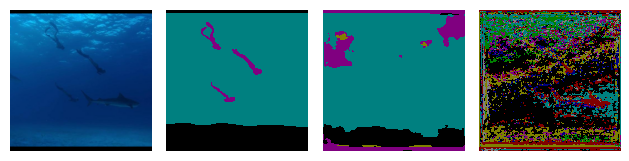

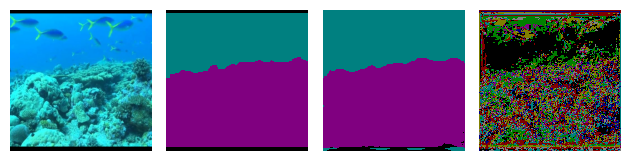

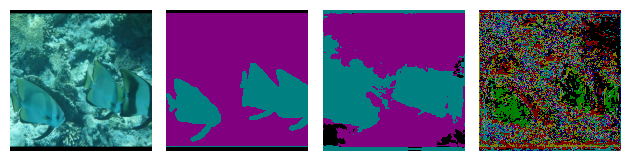

In [22]:
for i in range(3):
    index = np.random.randint(0, len(ds_train))
    image, label_masks, ground_truth = ds_train[index]
    image = image.unsqueeze(0)

    logits_unet = unet(image.to(device))
    probs_unet = F.softmax(logits_unet, dim=1)
    pred_unet = probs_unet.argmax(dim=(1), keepdim=True).cpu()

    logits_suim = suim_net(image.to(device))
    probs_suim = F.softmax(logits_suim, dim=1)
    pred_suim = probs_suim.argmax(dim=(1), keepdim=True).cpu()

    ts.show([image[0], ground_truth[0], pred_unet[0], pred_suim[0]])

## **Modellvergleich**

Es zeigt sich deutlich, dass das **UNet-Modell** signifikant bessere Ergebnisse erzielt als das **SuimNet**. Die Ursachen dafür können mehrere Gründe haben, darunter möglicherweise eine fehlerhafte Implementierung des SuimNet-Modells. Ein Indiz dafür ist, dass die Anzahl der Parameter beim SuimNet (3.75M) nicht mit dem in der Originalarbeit angegebenen Wert (3.83M) übereinstimmt. Bereits während des Trainings wurde beobachtet, dass die **Pixelgenauigkeit** des SuimNet unter **0.1** blieb und keine signifikante Verbesserung zeigte.

Im Gegensatz dazu erreichte das **UNet-Modell** während des Trainings eine Pixelgenauigkeit von bis zu **0.8**. Dies deutet darauf hin, dass das Modell in der Lage ist, relevante Merkmale aus den Daten zu lernen. Es ist anzunehmen, dass sich die Genauigkeit bei längerem Training weiter verbessern würde.

### **Testdaten**
Bei den Testdaten zeigt sich eine leichte Verschlechterung der Leistung des UNet-Modells im Vergleich zu den Trainingsdaten. Dennoch bleibt die Verschlechterung in einem akzeptablen Rahmen, was darauf hinweist, dass das Modell gut generalisiert und nicht übermäßig auf die Trainingsdaten abgestimmt ist (**Overfitting**).

### **Fazit**
- Das UNet-Modell zeigt sowohl während des Trainings als auch bei den Testdaten eine deutlich bessere Leistung als das SuimNet.
- Die schlechte Performance des SuimNet ist vermutlich auf eine nicht optimale Implementierung zurückzuführen, die möglicherweise die Architektur oder Trainingsparameter nicht korrekt berücksichtigt.

### **Potenzielle Maßnahmen zur Verbesserung**
- **SuimNet:** Überprüfung der Implementierung und Anpassung der Parameter gemäß der Originalarbeit.
- **UNet:** Durchführung eines längeren Trainings oder Anwendung von Techniken wie **Lernraten-Scheduling** oder **Datenaugmentation**, um die Generalisierungsfähigkeit weiter zu verbessern.
